# Data exploration and preparation
Inspect train data and its annotation

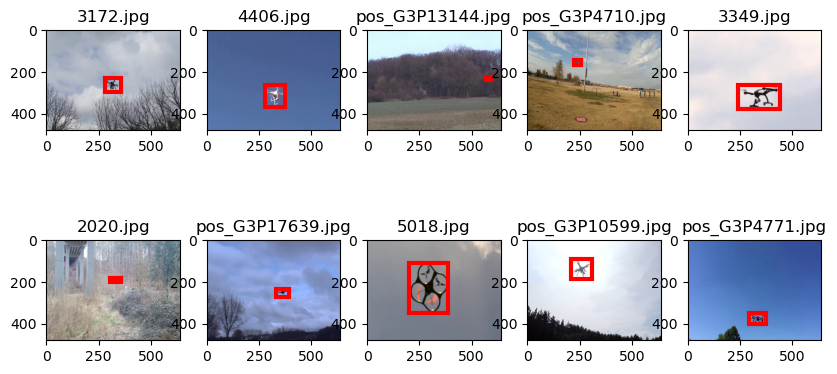

In [3]:
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

plt.rcParams['figure.figsize'] = [10, 5]

image_files = os.listdir('../datasets/Drone_TrainSet_100Snippet')
image_files_len = len(image_files)

# get 10 random images from dataset
idx = random.sample(range(image_files_len), 10)
fig, ax = plt.subplots(nrows=2, ncols=5)

def get_bounding_box_from_xml(file_path):
  tree = ET.parse(file_path)
  root = tree.getroot()
  xmin = root.find('object').find('bndbox').find('xmin').text
  ymin = root.find('object').find('bndbox').find('ymin').text
  xmax = root.find('object').find('bndbox').find('xmax').text
  ymax = root.find('object').find('bndbox').find('ymax').text

  x = int(xmin)
  y = int(ymin)
  width = int(xmax) - x
  height = int(ymax) - y
  return (x, y, width, height)


for i in range(5):
  id_1 = i * 2
  id_2 = i * 2 + 1

  img_1_path = image_files[idx[id_1]]
  img_2_path = image_files[idx[id_2]]

  img_1 = cv2.imread('../datasets/Drone_TrainSet_100Snippet/' + img_1_path)
  img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
  img_2 = cv2.imread('../datasets/Drone_TrainSet_100Snippet/' + img_2_path)
  img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

  img_1_xml = '../datasets/Drone_TrainSet_XMLs_100Snippet/' + img_1_path.replace('jpg', 'xml')
  x, y, width, height = get_bounding_box_from_xml(img_1_xml)
  rect_1 = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='none')
  plt.subplot(2, 5, id_1 + 1), plt.title(img_1_path), ax[0][i].imshow(img_1), ax[0][i].add_patch(rect_1)

  img_2_xml = '../datasets/Drone_TrainSet_XMLs_100Snippet/' + img_2_path.replace('jpg', 'xml')
  x, y, width, height = get_bounding_box_from_xml(img_2_xml)
  rect_2 = patches.Rectangle((x, y), width, height, linewidth=3, edgecolor='r', facecolor='none')
  plt.subplot(2, 5, id_2 + 1), plt.title(img_2_path), ax[1][i].imshow(img_2), ax[1][i].add_patch(rect_2)


Transform drone detection dataset from original to COCO format (compatible with YOLO).

In [8]:
!python ../utils/convert_drone_detection_dataset_to_yolo_format.py --train-input ../datasets/Drone_TrainSet_100Snippet/ --annotation-input ../datasets/Drone_TrainSet_XMLs_100Snippet/ --train-output ../datasets/drone_detection_yolo

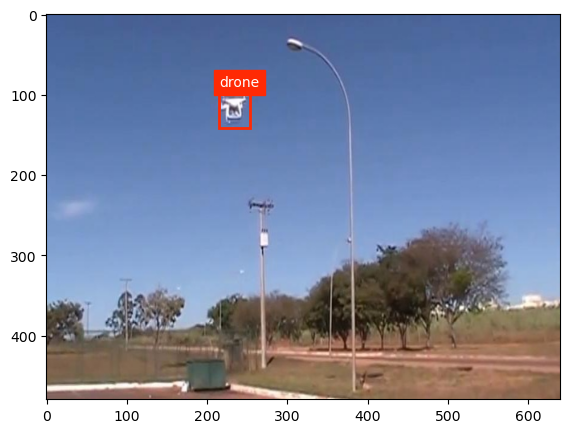

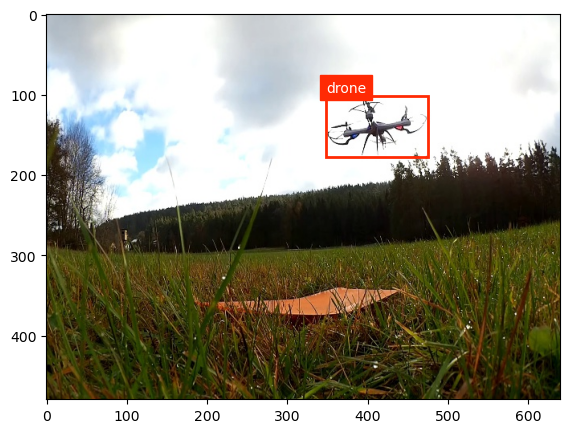

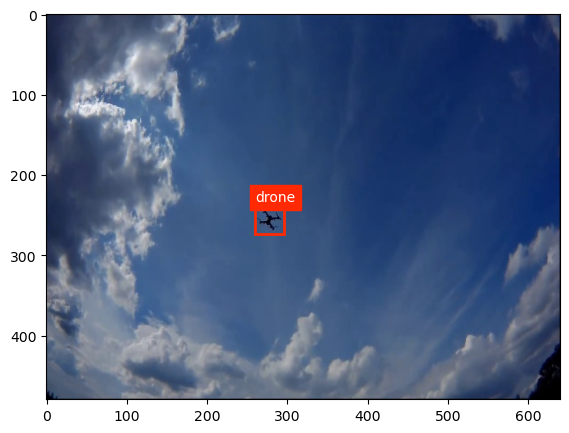

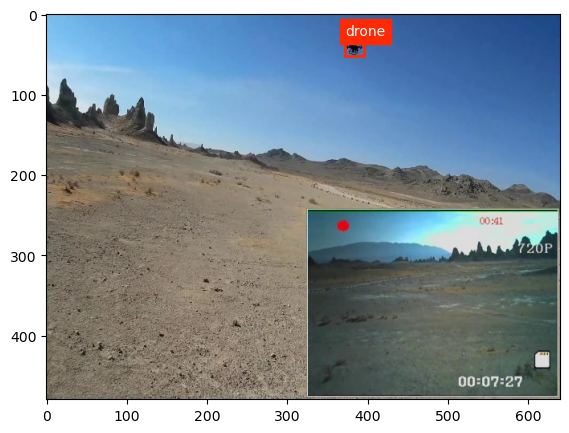

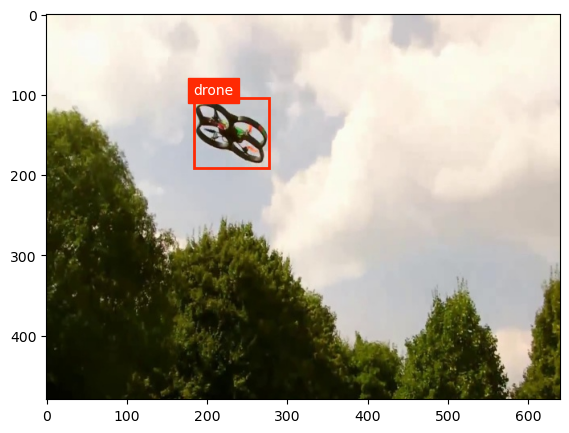

In [4]:
from ultralytics.data.utils import visualize_image_annotations

image_files = os.listdir('../datasets/drone_detection_yolo/images/train')
image_files_len = len(image_files)
label_map = { 0: "drone" }

# get 5 random images from dataset
idx = random.sample(range(image_files_len), 5)

for i in range(5):
  img_path = '../datasets/drone_detection_yolo/images/train/' + image_files[idx[i]]
  img_label = img_path.replace('images', 'labels').replace('jpg', 'txt')
  visualize_image_annotations(img_path, img_label, label_map)

In [5]:
# get size of samples
img = cv2.imread('../datasets/drone_detection_yolo/images/train/1007.jpg')
print(f"Width - {img.shape[1]}, height - {img.shape[0]}")

Width - 640, height - 480


# Detection
## Train model for detection task

In [8]:
from ultralytics import YOLO

model = YOLO("yolo11n.yaml")
results = model.train(data='../datasets/drone_detection_yolo/drone_detection_yolo.yaml', epochs=1)

Ultralytics 8.3.223 🚀 Python-3.13.9 torch-2.6.0 CPU (AMD Ryzen 5 5500U with Radeon Graphics)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../datasets/drone_detection_yolo/drone_detection_yolo.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience